In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Reference: https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb

In [2]:
import torch
from torch import nn

## We will sample from the following noisy sinusoidal function:
$$
y (x) = 7 \sin (\frac{3 x}{4}) + 0.5 x + \mathcal{N}(0,1)
$$

In [19]:
def generate_data(n_samples):
    epsilon = np.random.normal(size=(n_samples))
    x_data = np.random.uniform(-10.5, 10.5, n_samples)
    y_data = 7*np.sin(0.75*x_data) + 0.5*x_data + epsilon
    return np.expand_dims(x_data,-1), np.expand_dims(y_data,-1)
    
n_samples = 1000
x_data, y_data = generate_data(n_samples)

Text(0, 0.5, 'y')

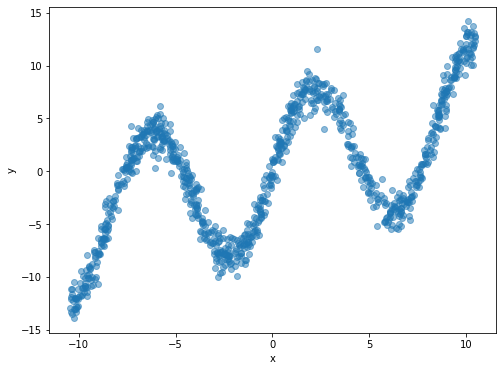

In [20]:
fig = figure(figsize=(8,6))

ax = fig.add_subplot(1,1,1)
ax.scatter(x_data,y_data,alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')

# Devine the Network that fits an MDN 

In [78]:
class MDN(nn.Module):
    def __init__(self, n_hidden, n_gaussians):
        super(MDN, self).__init__()
        
        # Hidden part 
        self.z_h = nn.Sequential(
            nn.Linear(in_features=1, out_features=n_hidden),
            nn.Tanh()
        )
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)  

        
        self.oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalization factor for Gaussians

    def forward(self, x):
        z_h = self.z_h(x)
        pi = nn.functional.softmax(self.z_pi(z_h), -1)
        sigma = torch.exp(self.z_sigma(z_h))
        mu = self.z_mu(z_h)
        return pi, sigma, mu
    
    def gaussian_distribution(self, y, mu, sigma):
        # make |mu|=K copies of y, subtract mu, divide by sigma
        result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
        result = -0.5 * (result * result)
        return (torch.exp(result) * torch.reciprocal(sigma)) * self.oneDivSqrtTwoPI

    def mdn_loss_fn(self, pi, sigma, mu, y):
        result = self.gaussian_distribution(y, mu, sigma) * pi
        result = torch.sum(result, dim=1)
        result = -torch.log(result)
        return torch.mean(result)
    

    def generate(self, x):
        pi, sigma, mu  = self.forward(x)

        # For each 
        pi_picked = torch.multinomial(pi,num_samples=1) # sample with probability pi one gaussian member1
        
        m = torch.distributions.categorical.Categorical(probs=pi)
        pi_picked = m.sample()
        
        #print (pi_picked.shape,pi.shape)
        res = torch.zeros(pi.shape[0])
        
        for batch_idx, r in enumerate(pi_picked):
            #print (i)
            res[batch_idx] = torch.normal(mu[batch_idx][r], sigma[batch_idx][r])
        return res

    

In [79]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [89]:
net = MDN(n_hidden=256, n_gaussians=16).to(device)
optimizer = torch.optim.Adam(net.parameters())

In [90]:
epochs = 10000
batch_size=256
loss_save = []
loss_min = 1000.0

In [91]:
for epoch in range(epochs):
    
    # Reverse the order of the data
    #y_data, x_data = generate_data(batch_size)
        
    # Or fit the original order 
    x_data, y_data = generate_data(batch_size)
        
    x = torch.tensor(x_data).to(torch.float32).to(device)
    y = torch.tensor(y_data).to(torch.float32).to(device)
    pi, sigma, mu = net(x)
    loss = net.mdn_loss_fn(pi, sigma, mu, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_scalar = loss.item()
    
    if loss_min >= loss_scalar:
        loss_min = loss_scalar
        torch.save(net.state_dict(),r'best_model.params')

    
    
    loss_save += [loss_scalar]
    if epoch % 500 == 0:
        print("Epoch::{}, loss::{}".format(epoch, loss_scalar))


Epoch::0, loss::7.4251861572265625
Epoch::500, loss::2.1058900356292725
Epoch::1000, loss::1.956681489944458
Epoch::1500, loss::1.767730951309204
Epoch::2000, loss::1.5945284366607666
Epoch::2500, loss::1.4943649768829346
Epoch::3000, loss::1.508169412612915
Epoch::3500, loss::1.5105535984039307
Epoch::4000, loss::1.4234379529953003
Epoch::4500, loss::1.4225378036499023
Epoch::5000, loss::1.4614334106445312
Epoch::5500, loss::1.5469071865081787
Epoch::6000, loss::1.5264654159545898
Epoch::6500, loss::1.5058975219726562
Epoch::7000, loss::1.4402114152908325
Epoch::7500, loss::1.433857798576355
Epoch::8000, loss::1.4635593891143799
Epoch::8500, loss::1.4881064891815186
Epoch::9000, loss::1.4429802894592285
Epoch::9500, loss::1.4437222480773926


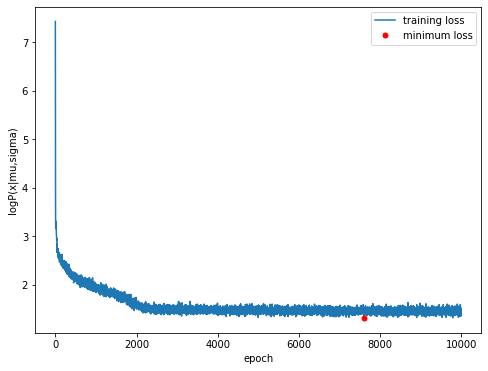

In [92]:
fig = figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.plot(loss_save,label='training loss')
ax.set_xlabel('epoch')
ax.set_ylabel('logP(x|mu,sigma)')
ax.plot(np.argmin(loss_save),loss_min,'ro',ms=5,label='minimum loss')
legend()

In [93]:
net.load_state_dict(torch.load('best_model.params'))
net.eval() ;

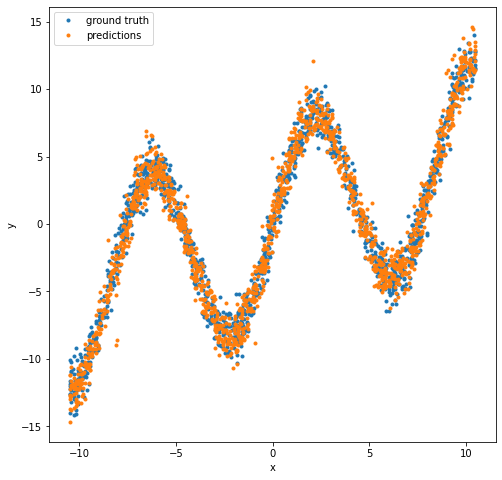

In [95]:
x, y = generate_data(1500)
xsample = torch.tensor(x).to(torch.float32).to(device)
ysim = net.generate(xsample).detach().numpy()
fig = figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)

ax.plot(x,y,'.',label='ground truth')
ax.plot(x.squeeze(),ysim,'.',label='predictions')
ax.set_xlabel('x')
ax.set_ylabel('y')
legend()
#ax.set_aspect('equal')

## Repeat with reverse order of x,y variables/

In [82]:
net = MDN(n_hidden=256, n_gaussians=16).to(device)
optimizer = torch.optim.Adam(net.parameters())

In [83]:
epochs = 10000
batch_size=256
loss_save = []
loss_min = 1000.0

In [84]:
for epoch in range(epochs):
    
    # Reverse the order of the data
    y_data, x_data = generate_data(batch_size)
        
    # Or fit the original order 
    #x_data, y_data = generate_data(batch_size)
        
    x = torch.tensor(x_data).to(torch.float32).to(device)
    y = torch.tensor(y_data).to(torch.float32).to(device)
    pi, sigma, mu = net(x)
    loss = net.mdn_loss_fn(pi, sigma, mu, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_scalar = loss.item()
    
    if loss_min >= loss_scalar:
        loss_min = loss_scalar
        torch.save(net.state_dict(),r'best_model.params')

    
    
    loss_save += [loss_scalar]
    if epoch % 500 == 0:
        print("Epoch::{}, loss::{}".format(epoch, loss_scalar))


Epoch::0, loss::7.452750205993652
Epoch::500, loss::1.7946269512176514
Epoch::1000, loss::1.5468690395355225
Epoch::1500, loss::1.5331926345825195
Epoch::2000, loss::1.35334312915802
Epoch::2500, loss::1.5057367086410522
Epoch::3000, loss::1.4223096370697021
Epoch::3500, loss::1.3910073041915894
Epoch::4000, loss::1.4266197681427002
Epoch::4500, loss::1.3884435892105103
Epoch::5000, loss::1.4632270336151123
Epoch::5500, loss::1.3516091108322144
Epoch::6000, loss::1.4150135517120361
Epoch::6500, loss::1.41037917137146
Epoch::7000, loss::1.404000997543335
Epoch::7500, loss::1.3037008047103882
Epoch::8000, loss::1.4154188632965088
Epoch::8500, loss::1.4097449779510498
Epoch::9000, loss::1.4513514041900635
Epoch::9500, loss::1.4303803443908691


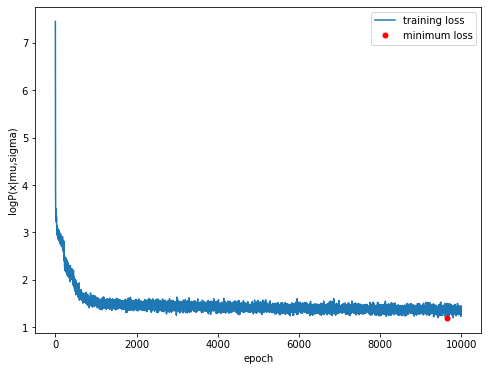

In [85]:
fig = figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.plot(loss_save,label='training loss')
ax.set_xlabel('epoch')
ax.set_ylabel('logP(x|mu,sigma)')
ax.plot(np.argmin(loss_save),loss_min,'ro',ms=5,label='minimum loss')
legend()

In [86]:
net.load_state_dict(torch.load('best_model.params'))
net.eval() ;

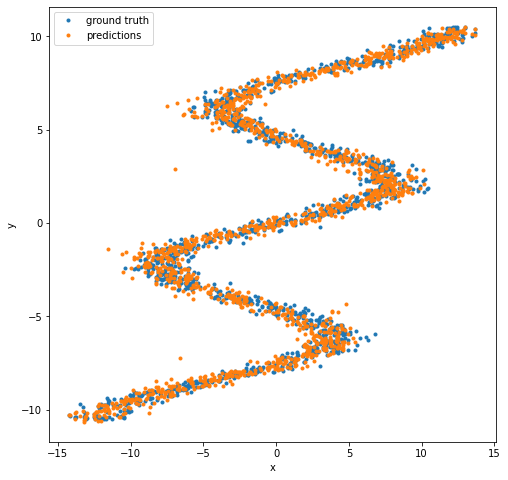

In [88]:
#Note: reverse order of x,y variables
y, x = generate_data(1500)

xsample = torch.tensor(x).to(torch.float32).to(device)
ysim = net.generate(xsample).detach().numpy()
fig = figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)

ax.plot(x,y,'.',label='ground truth')
ax.plot(x.squeeze(),ysim,'.',label='predictions')
ax.set_xlabel('x')
ax.set_ylabel('y')
legend()
#ax.set_aspect('equal')